<a href="https://colab.research.google.com/github/benbrill/MoodSpace/blob/main/tfLyricClassifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import re
import string

from tensorflow.keras import layers

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/benbrill/MoodSpace/main/data/trainingSongs_clean.csv")
df

,Unnamed: 0,trackName,artist,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,lyrics,cluster,language
0,3,Overthinker,INZO,4K9xid96G3YmIvQZXN9SXg,0.472,0.605,8.0,-4.437,1.0,0.1340,0.03110,0.030800,0.1010,0.212,128.375,audio_features,a person who thinks all the time has nothing t...,0,en
1,4,Lifestyles of the Rich & Famous,Good Charlotte,2g2a5kDeZexbUTD8abcvm6,0.620,0.930,1.0,-3.685,1.0,0.0374,0.00043,0.000000,0.0686,0.609,106.220,audio_features,always see it on t v or read in the magazines ...,3,en
2,6,Carrying Your Love With Me,George Strait,7puxIVNdj5nsBJk43zM3bH,0.629,0.479,10.0,-10.608,1.0,0.0271,0.22000,0.000000,0.0587,0.345,138.231,audio_features,baby all i got is this beat up leather bag and...,5,en
3,7,"Check Yes, Juliet",We The Kings,0wVluBsVAVzBKrqspuCcwR,0.352,0.912,7.0,-4.253,1.0,0.0725,0.00197,0.000000,0.1930,0.351,166.795,audio_features,check yes juliet are you with me rain is falli...,2,en
4,8,At My Worst (feat. Kehlani),Pink Sweat$,58w68w4s8h9gw3xrDaXyuj,0.731,0.484,0.0,-5.579,1.0,0.0354,0.73000,0.000003,0.3260,0.350,92.043,audio_features,can i call you baby can you be my friend can y...,1,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,994,90mh,Trefuego,1VxvGm1moDJ3svQlwjdBwA,0.716,0.427,1.0,-8.993,1.0,0.0529,0.18700,0.000000,0.3540,0.223,108.993,audio_features,hi kevin ayy yeah ayy ayy you dont really want...,3,en
713,995,9 Bridge,Rowdy Rebel,2sHekv6OdEiO4htSjdB9j4,0.642,0.589,5.0,-7.392,0.0,0.3020,0.12400,0.000000,0.0868,0.720,95.543,audio_features,i know i dont never make promises this time i ...,1,en
714,996,Lotus Flower Bomb (feat. Miguel),Wale,3MAgQuClHcAV8E9CbeBS6f,0.512,0.598,9.0,-4.959,0.0,0.1150,0.61100,0.000000,0.0881,0.345,70.189,audio_features,ima rap to you real quick i wanna enjoy the lu...,4,en
715,997,Envy Me,Calboy,7rvyVWja33WG9R97oeJAjx,0.740,0.488,1.0,-7.664,0.0,0.2700,0.23400,0.000000,0.2410,0.584,149.042,audio_features,now i lay me down to sleep now i lay me down t...,5,en


In [3]:
# only the top distinct words will be tracked
max_tokens = 2000

# each headline will be a vector of length 25
sequence_length = 500

vectorize_layer = TextVectorization(
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length) 

In [4]:
vectorize_layer.adapt(df['lyrics'].to_numpy())

In [ ]:
model.save_weights('my_checkpoint_30')

In [ ]:
X = vectorize_layer(df['lyrics']).numpy().astype("int32")
y = df[["energy", "valence", "tempo", "liveness"]].to_numpy().astype("float32")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42)

In [6]:
lyrics_features = None
lyrics_input = keras.Input(
    shape = (500,), 
    name = "lyrics",
    dtype = "int32"
)
lyrics_features = layers.Embedding(max_tokens, 60, name = "embedding")(lyrics_input)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.Conv1D(64, 5, activation='relu')(lyrics_features)
lyrics_features = layers.MaxPooling1D(pool_size=4)(lyrics_features)
lyrics_features = layers.LSTM(100)(lyrics_features)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.Dense(64, activation='relu')(lyrics_features)
lyrics_features = layers.Dense(32, activation='relu')(lyrics_features)
output1 = layers.Dense(4, name = "metrics")(lyrics_features)

In [ ]:
model = keras.Model(inputs=lyrics_input, outputs=[output1])

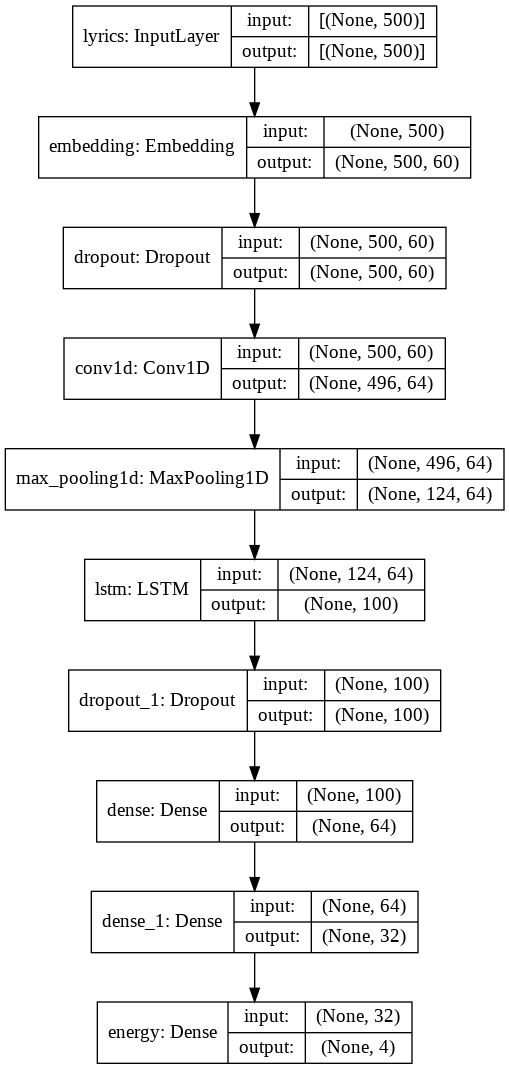

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lyrics (InputLayer)             [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 60)      120000      lyrics[0][0]                     
__________________________________________________________________________________________________
dropout_53 (Dropout)            (None, 500, 60)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 496, 64)      19264       dropout_53[0][0]                 
___________________________________________________________________________________________

In [ ]:
model.compile(loss='mae',
              optimizer='adam', 
              metrics=['RootMeanSquaredError', 'msle'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
20/20 [==============================] - 2s 40ms/step - loss: 5.2972 - root_mean_squared_error: 13.1768 - msle: 0.0413 - val_loss: 6.0822 - val_root_mean_squared_error: 14.5588 - val_msle: 0.0406
Epoch 2/100
20/20 [==============================] - 0s 19ms/step - loss: 5.1303 - root_mean_squared_error: 13.0529 - msle: 0.0295 - val_loss: 6.1220 - val_root_mean_squared_error: 14.7890 - val_msle: 0.0323
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 5.1915 - root_mean_squared_error: 13.2759 - msle: 0.0292 - val_loss: 6.0504 - val_root_mean_squared_error: 14.5697 - val_msle: 0.0359
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 5.1819 - root_mean_squared_error: 13.1833 - msle: 0.0281 - val_loss: 5.9840 - val_root_mean_squared_error: 14.4073 - val_msle: 0.0404
Epoch 5/100
20/20 [==============================] - 0s 17ms/step - loss: 5.1767 - root_mean_squared_error: 13.1216 - msle: 0.0303 - val_loss: 6.1567 - val_root_mean_sq

In [ ]:
y_pred = model.predict(test_vec)
y_pred

array([[8.19004238e-01, 5.68767369e-01, 1.20781769e+02, 1.39735758e-01],
       [8.21692646e-01, 5.67810237e-01, 1.37120056e+02, 1.38591588e-01],
       [7.41004169e-01, 5.30588329e-01, 9.63846436e+01, 1.41068399e-01],
       [8.17588031e-01, 5.70221007e-01, 1.28002625e+02, 1.38707459e-01],
       [8.15367877e-01, 5.70307672e-01, 1.27066772e+02, 1.39688671e-01],
       [7.97209918e-01, 5.55274308e-01, 1.09956421e+02, 1.39641345e-01],
       [7.87616909e-01, 5.50020516e-01, 1.08131294e+02, 1.36341512e-01],
       [8.15884769e-01, 5.70778906e-01, 1.25039810e+02, 1.38503015e-01],
       [8.05232227e-01, 5.49657762e-01, 1.18400673e+02, 1.59737051e-01],
       [8.22045505e-01, 5.69338143e-01, 1.21649666e+02, 1.40306056e-01],
       [8.06620777e-01, 5.57498872e-01, 1.12266449e+02, 1.40181243e-01],
       [8.12678516e-01, 5.64774573e-01, 1.16704727e+02, 1.39210165e-01],
       [8.07111919e-01, 5.61204731e-01, 1.13588043e+02, 1.39889419e-01],
       [8.17326725e-01, 5.67912281e-01, 1.19734871e

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 7ms/step - loss: 6.8692 - root_mean_squared_error: 17.4515 - msle: 0.0566


[6.869185924530029, 17.451522827148438, 0.05663616210222244]

In [ ]:
def stringProcessing(s):
    s = re.sub(r"\'", "", s)
    s = re.sub(r'\n', ' ', s)
    s = re.sub(r'\t', '', s)
    s = re.sub(r"\[[^[]*\]", '', s)
    s = re.sub(r'[^\w\s]', ' ', s)
    s = re.sub(r' +', ' ', s)
    s = s.strip()
    s = s.lower()
    return s
def vectorize_movie_scripts(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [ ]:
import os
# model = create_model(

# df = pd.read_csv("https://raw.githubusercontent.com/benbrill/MoodSpace/main/data/trainingSongs_clean.csv")

# data = tf.data.Dataset.from_tensor_slices((df["lyrics"]))
# data_vec = data.map(vectorize_headline)
# df = pd.DataFrame(model.predict(data_vec))
# df.shape
d = {}
for script_path in os.listdir("scripts"):
    with open(f"scripts/{script_path}") as f:
        contents = f.read()

        contents = stringProcessing(contents)

        df = pd.DataFrame({"lyrics": [contents]})
        
        vectorize_layer.adapt(df["lyrics"].to_numpy())
        X = vectorize_layer(df["lyrics"])
        pred = model.predict(X)
        # pred = np.concatenate((pred[0], pred[1], pred[2], pred[3]), axis = 1)
        d[script_path] = pred
        print(script_path, pred)

goodwillhunting.txt [[  0.68880993   0.8374711  127.36825      0.32526487]]
incredibles.txt [[  0.61182505   0.7656008  119.531586     0.32334226]]
shawshank.txt [[  0.67126805   0.7803217  113.69474      0.3003177 ]]
forrest.txt [[  0.6130405    0.76450646 120.57039      0.3245706 ]]
titanic.txt [[  0.67285687   0.79128706 120.59113      0.3098392 ]]
deadpoets.txt [[  0.64475733   0.7955104  124.38414      0.33660215]]
khan.txt [[ 0.6255594   0.74936783 96.756516    0.275114  ]]
jedi.txt [[  0.6867376   0.8403317 126.17185     0.3247375]]
bourne.txt [[  0.6419812   0.7967564 140.30386     0.3444404]]
fellowship.txt [[  0.6545988    0.81530297 122.697586     0.33262438]]


In [ ]:
model.save_weights("my_checkpoint_30")